Lab3 Multiclass predictions. Carlos Garcia - 21000475

In [1]:
import tensorflow as tf
from tensorflow import keras

import numpy as np
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt

In [2]:
if tf.__version__.startswith("2."):
  import tensorflow.compat.v1 as tf
  tf.compat.v1.disable_v2_behavior()
  tf.compat.v1.disable_eager_execution()
  print("Enabled compatitility to tf1.x")

Instructions for updating:
non-resource variables are not supported in the long term
Enabled compatitility to tf1.x


## Cargamos la data 

El dataset Fashion-MNIST cotiene 60,00 imagenes para el set de datos de entrenamiento y un set de datos de prueba de 10,000.

In [3]:
fashion_mnist = keras.datasets.fashion_mnist

In [4]:
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

## Imagenes
Las imagenes son Numpy Arrays de 28x28, los pixeles estan entre los valores de 0 a 255

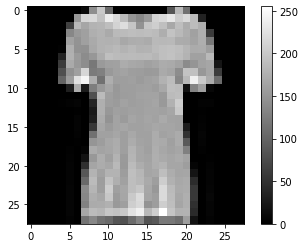

In [5]:
plt.imshow(train_images[10], cmap = 'gray')
plt.colorbar()

## Labels

In [6]:
np.unique(train_labels)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

| Label | Class       |
|-------|-------------|
| 0     | T-shirt/top |
| 1     | Trouser     |
| 2     | Pullover    |
| 3     | Dress       |
| 4     | Coat        |
| 5     | Sandal      |
| 6     | Shirt       |
| 7     | Sneaker     |
| 8     | Bag         |
| 9     | Ankle boot  |

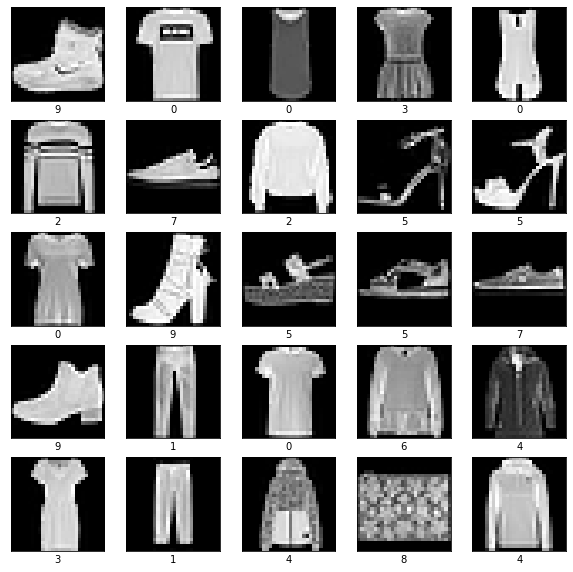

In [7]:
plt.figure(figsize=(10,10))

for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i], cmap='gray')
    plt.xlabel(train_labels[i])
plt.show()

# Tarea

Para esta tarea se deben utilizar únicamente 3 clases, se puede escoger cualquiera de las 10 disponibles en el data set, por lo que hay que filtrar las clases elegidas en los arreglos:
- train_images
- train_labels
- test_images
- test_labels

El objetivo de la tarea es comparar la diferencia al aplicar feature scale/normalization y las features sin ninguna transformación y comparar el efecto de el scaling/normalización sobre el entrenamiento con regresión logística.
- Se debe crear un diccionario con el valor numérico de las labels y el texto correspondiente para poder relacionar el valor numérico con el valor descriptivo/textual.
- Aplicar regresión logística con entropía cruzada como función de costo, crear una función que recibe de entrada un tensor x y predice la clase(utilizar el diccionario para mostrar el texto perteneciente al label).
- Adicional a el costo(por entropía cruzada) en el grafo se debe agregar un nodo que calcule el acurracy(comparando el valor real vs el estimado por el modelo).
- El accuracy y el costo deben ser agregados a tensorboard (agregar screenshots al notebook)
- Se debe agregar al notebook un screenshot del grafo/grafos de tensorboard, simplificando(usando names y name_scope como visto en clase).
- Todo lo anterior se debe hacer tanto para datos crudos, como para datos transformados con (normalización y escalado)
- Basado en los ejemplos de visualización de imagenes en el notebook ,crear una función que reciba de entrada el tensor que representa a una imagen, grafique esta imagen poniendo como título el nombre de la prenda con mayor probabilidad.
- Utilizar la función anterior para mostrar una muestra aleatoria de 5 imágenes(y la predicción probabilistica de la prenda)
- Comparar con tensorboard las curvas de aprendizaje del entrenamiento con datos crudos vs datos transformados, y los 2 grafos y concluir/opinar al respecto usando markdown(agregando screenshots)
- Utilizar mini batch gradient descent con batch size de 32

### Data preparation

In [8]:
train_indexes = np.where(train_labels < 3)
test_indexes = np.where(test_labels < 3)

train_labels = train_labels[train_indexes]
train_images = train_images[train_indexes]
test_labels = test_labels[test_indexes]
test_images = test_images[test_indexes]

In [9]:
labels_dictionary = dict()
labels_dictionary[0] = 'T-shirt/top'
labels_dictionary[1] = 'Trouser'
labels_dictionary[2] = 'Pullover'

print(labels_dictionary)

{0: 'T-shirt/top', 1: 'Trouser', 2: 'Pullover'}


In [15]:
scaler = MinMaxScaler()
scaled_train_images = np.array([scaler.fit_transform(img) for img in train_images])
scaled_test_images = np.array([scaler.fit_transform(img) for img in test_images])

### Training model

In [16]:
def trainModel(x, y,  epochs = 100, batch_size = 32, lr = 0.01, kprint = 10, scaled_str = 'normal'):
    
    #Get total iterations
    iters = x.shape[0] // batch_size

    #Initialize the graph
    tf.reset_default_graph()

    #Defining tensors and variables 
    X = tf.placeholder(dtype = tf.float32, shape = [None, 785], name = 'input_images') #n x 785
    labels = tf.placeholder(dtype = tf.int32, shape = [None, 3], name = 'class_labels') # n x 1
    W = tf.get_variable(name = 'weights', shape = [785, 3], dtype = tf.float32, initializer = tf.zeros_initializer()) #785 x 1

    #Estimating values
    Z = tf.matmul(X, W, name = 'logit')
    preds = tf.nn.softmax(Z, name = 'yhat')

    #Calculating cost function (cross entropy)
    with tf.name_scope('cost_function'):
        loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels = labels, logits = Z, name = 'loss'))

    #Tensorboard scalar summary
    loss_summary = tf.summary.scalar(name = 'CrossEntropy', tensor = loss)

    #Calculatin accuracy
    with tf.name_scope('accuracy_definition'):
        correct_prediction = tf.equal(tf.argmax(preds, axis = 1), tf.argmax(labels, axis = 1), name = 'compare_labels')
        accuracy_tensor = tf.reduce_mean(tf.cast(correct_prediction, tf.float32), name = 'accuracy_metric')

    #Tensorboard scalar accuracy
    accuracy_summary = tf.summary.scalar(name = 'Accuracy', tensor = accuracy_tensor)

    #Gradient and cost error optimization
    with tf.name_scope('optimize_loss'):
        gradients = tf.gradients(loss, [W], name = 'gradients')
        optimizer = tf.assign(W, W - lr * gradients[0], name = 'optimizer')


    with tf.Session() as session:

        #Initialize global vars
        session.run(tf.global_variables_initializer())

        #Reshaping data
        x = x.reshape(x.shape[0], -1)
        ones = np.expand_dims(np.ones_like(x[:,0]), axis = 1)
        x = np.hstack((ones, x))

        ohe = OneHotEncoder()
        y = ohe.fit_transform(np.expand_dims(y, axis = 1)).toarray()

        #Whole batch dictionary
        feed_dict_model = {X:x, labels:y}

        #Define tensorflow writer
        dt_string = datetime.now().strftime("%Y%m%d_%H%M")
        writer = tf.summary.FileWriter('./graphs/{}_softmax_{}_epochs={}_mbatch={}_lr={}'.format(dt_string, scaled_str, epochs, batch_size, lr), session.graph)

        for epoch in range(0, epochs):
            for i in range(0, iters):
                start_sample = i * batch_size
                end_smaple = start_sample + batch_size
                x_mb = x[start_sample:end_smaple]
                y_mb = y[start_sample:end_smaple]

                feed_dict = {X:x_mb, labels:y_mb}
                _, weights = session.run([optimizer, W], feed_dict = feed_dict)
            
            predictions = session.run([preds], feed_dict = feed_dict_model)
            cross_entropy, lsummary = session.run([loss, loss_summary], feed_dict = feed_dict_model)
            writer.add_summary(lsummary, epoch + 1)

            cpreds, accuracy, asummary = session.run([correct_prediction, accuracy_tensor, accuracy_summary], feed_dict = feed_dict_model)
            writer.add_summary(asummary, epoch + 1)

            if (epoch + 1) % kprint == 0:
                print("Epoch {}: CrossEntropy={} --- Accuracy={}".format(epoch + 1, cross_entropy, accuracy))
       

        #Calculate final model metrics
        _, weights = session.run([optimizer, W], feed_dict = feed_dict_model)
        predictions, cross_entropy = session.run([preds, loss], feed_dict = feed_dict_model)
        cpreds, accuracy = session.run([correct_prediction, accuracy_tensor], feed_dict = feed_dict_model)
        print("Final model: CrossEntropy={} --- Accuracy={}".format(cross_entropy, accuracy))

        #Close tensorboard writer
        writer.close()

        return (weights)

#### Model graph

<img src="./imgs/model_graph.png">

#### Experiments with data as is

In [17]:
#Experiment 1
output_weights = trainModel(train_images, train_labels, epochs = 100, batch_size = 32, lr = 0.01, kprint = 10)

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.

Epoch 10: CrossEntropy=175.6027069091797 --- Accuracy=0.968999981880188
Epoch 20: CrossEntropy=162.9427947998047 --- Accuracy=0.9717222452163696
Epoch 30: CrossEntropy=146.4796600341797 --- Accuracy=0.9705555438995361
Epoch 40: CrossEntropy=186.689208984375 --- Accuracy=0.9701666831970215
Epoch 50: CrossEntropy=203.82818603515625 --- Accuracy=0.9649444222450256
Epoch 60: CrossEntropy=168.10533142089844 --- Accuracy=0.9733333587646484
Epoch 70: CrossEntropy=96.47306823730469 --- Accuracy=0.9753888845443726
Epoch 80: CrossEntropy=103.13177490234375 --- Accuracy=0.9752222299575806
Epoch 90: CrossEntropy=107.57302856445312 --- Accuracy=0.9708333611488342
Epoch 100: CrossEntropy=106.04060363769531 --- Accuracy=0.9764444231987
Final model: CrossEntropy=97.63191986083984 --- Accuracy=0.9776666760444641


In [18]:
#Experiment 2
output_weights = trainModel(train_images, train_labels, epochs = 100, batch_size = 32, lr = 0.001, kprint = 10)

Epoch 10: CrossEntropy=18.53005027770996 --- Accuracy=0.9720555543899536
Epoch 20: CrossEntropy=17.4515380859375 --- Accuracy=0.972777783870697
Epoch 30: CrossEntropy=12.836512565612793 --- Accuracy=0.9722222089767456
Epoch 40: CrossEntropy=17.76768684387207 --- Accuracy=0.9707777500152588
Epoch 50: CrossEntropy=15.845231056213379 --- Accuracy=0.9733333587646484
Epoch 60: CrossEntropy=12.16211986541748 --- Accuracy=0.9755555391311646
Epoch 70: CrossEntropy=11.889805793762207 --- Accuracy=0.9756110906600952
Epoch 80: CrossEntropy=12.274109840393066 --- Accuracy=0.9734444618225098
Epoch 90: CrossEntropy=11.831673622131348 --- Accuracy=0.9725000262260437
Epoch 100: CrossEntropy=10.62667179107666 --- Accuracy=0.976722240447998
Final model: CrossEntropy=10.43387508392334 --- Accuracy=0.977222204208374


In [19]:
#Experiment 3
output_weights = trainModel(train_images, train_labels, epochs = 100, batch_size = 32, lr = 0.0001, kprint = 10)

Epoch 10: CrossEntropy=1.835619330406189 --- Accuracy=0.9683889150619507
Epoch 20: CrossEntropy=2.0027518272399902 --- Accuracy=0.9672777652740479
Epoch 30: CrossEntropy=1.3722819089889526 --- Accuracy=0.9714444279670715
Epoch 40: CrossEntropy=1.4097131490707397 --- Accuracy=0.971833348274231
Epoch 50: CrossEntropy=1.0554169416427612 --- Accuracy=0.977055549621582
Epoch 60: CrossEntropy=1.9701766967773438 --- Accuracy=0.9687222242355347
Epoch 70: CrossEntropy=0.9637328386306763 --- Accuracy=0.9754999876022339
Epoch 80: CrossEntropy=0.9807083606719971 --- Accuracy=0.9756110906600952
Epoch 90: CrossEntropy=2.0768861770629883 --- Accuracy=0.968833327293396
Epoch 100: CrossEntropy=1.111430287361145 --- Accuracy=0.9764444231987
Final model: CrossEntropy=1.0340640544891357 --- Accuracy=0.9767777919769287


In [20]:
#Experiment 4
output_weights = trainModel(train_images, train_labels, epochs = 100, batch_size = 32, lr = 0.00001, kprint = 10)

Epoch 10: CrossEntropy=0.19898833334445953 --- Accuracy=0.9714999794960022
Epoch 20: CrossEntropy=0.1614048331975937 --- Accuracy=0.9729999899864197
Epoch 30: CrossEntropy=0.1362781524658203 --- Accuracy=0.9748333096504211
Epoch 40: CrossEntropy=0.1342652589082718 --- Accuracy=0.9756666421890259
Epoch 50: CrossEntropy=0.1265546828508377 --- Accuracy=0.9754999876022339
Epoch 60: CrossEntropy=0.11718614399433136 --- Accuracy=0.9763888716697693
Epoch 70: CrossEntropy=0.11318536847829819 --- Accuracy=0.9768333435058594
Epoch 80: CrossEntropy=0.1009499654173851 --- Accuracy=0.9775555729866028
Epoch 90: CrossEntropy=0.10686694085597992 --- Accuracy=0.975944459438324
Epoch 100: CrossEntropy=0.09745950251817703 --- Accuracy=0.9784444570541382
Final model: CrossEntropy=0.09673165529966354 --- Accuracy=0.9784444570541382


In [21]:
output_weights.shape

(785, 3)

<img src="./imgs/Accuracy_as_is.png">
<img src="./imgs/CrossEntropy_as_is.png">

#### Experiments with scaled data

In [24]:
#Experiment 1
output_weights_s = trainModel(scaled_train_images, train_labels, epochs = 100, batch_size = 32, lr = 0.01, kprint = 10, scaled_str = 'scaled')

Epoch 10: CrossEntropy=0.09755216538906097 --- Accuracy=0.9695000052452087
Epoch 20: CrossEntropy=0.08890009671449661 --- Accuracy=0.9722222089767456
Epoch 30: CrossEntropy=0.08432918041944504 --- Accuracy=0.9737777709960938
Epoch 40: CrossEntropy=0.08123639225959778 --- Accuracy=0.9745555520057678
Epoch 50: CrossEntropy=0.07890655845403671 --- Accuracy=0.9753888845443726
Epoch 60: CrossEntropy=0.07703930139541626 --- Accuracy=0.9758333563804626
Epoch 70: CrossEntropy=0.07548090070486069 --- Accuracy=0.9758889079093933
Epoch 80: CrossEntropy=0.07414285093545914 --- Accuracy=0.9764444231987
Epoch 90: CrossEntropy=0.07296976447105408 --- Accuracy=0.9766666889190674
Epoch 100: CrossEntropy=0.07192487269639969 --- Accuracy=0.9769444465637207
Final model: CrossEntropy=0.07189957797527313 --- Accuracy=0.9769999980926514


In [23]:
#Experiment 2
output_weights_s = trainModel(scaled_train_images, train_labels, epochs = 100, batch_size = 32, lr = 0.001, kprint = 10, scaled_str = 'scaled')

Epoch 10: CrossEntropy=0.14364878833293915 --- Accuracy=0.9564444422721863
Epoch 20: CrossEntropy=0.1255958527326584 --- Accuracy=0.9599999785423279
Epoch 30: CrossEntropy=0.11683763563632965 --- Accuracy=0.9623888731002808
Epoch 40: CrossEntropy=0.1113261952996254 --- Accuracy=0.9646666646003723
Epoch 50: CrossEntropy=0.10741331428289413 --- Accuracy=0.9662222266197205
Epoch 60: CrossEntropy=0.10443045943975449 --- Accuracy=0.9674999713897705
Epoch 70: CrossEntropy=0.10204676538705826 --- Accuracy=0.9680555462837219
Epoch 80: CrossEntropy=0.10007653385400772 --- Accuracy=0.9686111211776733
Epoch 90: CrossEntropy=0.0984060987830162 --- Accuracy=0.9691110849380493
Epoch 100: CrossEntropy=0.09696146100759506 --- Accuracy=0.9696666598320007
Final model: CrossEntropy=0.09696119278669357 --- Accuracy=0.9696666598320007


<img src="./imgs/Accuracy_scaled.png">
<img src="./imgs/CrossEntropy_scaled.png">

### Model Predictions

In [26]:
def getPredictions(x_predict, weights, labels):

    #Initialize the graph
    tf.reset_default_graph()

    #Defining tensors and variables 
    X = tf.placeholder(dtype = tf.float32, shape = [None, 785], name = 'test_images') #n x 785
    W = tf.placeholder(dtype = tf.float32, shape = [785, 3], name = 'weights') # n x 1

    #Estimating values
    Z = tf.matmul(X, W, name = 'logit')
    ohe_preds = tf.nn.softmax(Z, name = 'ohe_preds')
    preds = tf.argmax(ohe_preds, axis = 1)

    with tf.Session() as session:

        #Initialize global vars
        session.run(tf.global_variables_initializer())

        #Reshaping data
        x = x_predict.reshape(x_predict.shape[0], -1)
        ones = np.expand_dims(np.ones_like(x[:,0]), axis = 1)
        x = np.hstack((ones, x))

        ohe = OneHotEncoder()
        y = ohe.fit_transform(np.expand_dims(labels, axis = 1)).toarray()
        categories = ohe.categories_[0]

        #Whole batch dictionary
        feed_dict = {X:x, W:weights}
        
        #Making the predictions
        predictions = session.run([preds], feed_dict = feed_dict)

        return (categories[predictions[0]])


In [27]:
predictions = getPredictions(scaled_test_images, output_weights_s, test_labels)

### Predict sample

In [33]:
def plotPredictions(x_test, y_test, weights, labels_dictionary):

    predictions = getPredictions(x_test, weights, y_test)
    indexes = np.random.randint(low = 0, high = len(predictions) ,size = 5)

    for i in indexes:
        print('Predicted label: {}'.format(labels_dictionary[predictions[i]]))
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(x_test[i], cmap='gray')
        plt.xlabel(labels_dictionary[y_test[i]])
        plt.show()

    

Predicted label: T-shirt/top


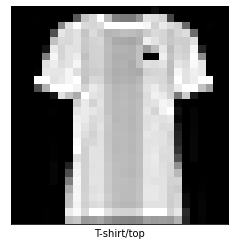

Predicted label: Pullover


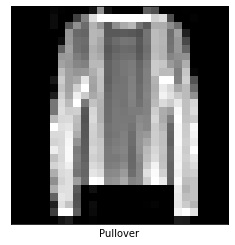

Predicted label: Trouser


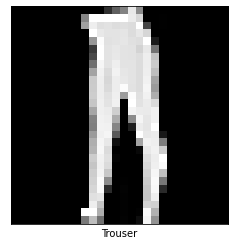

Predicted label: Trouser


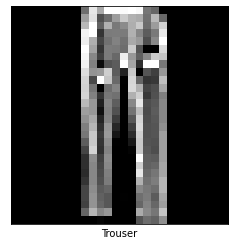

Predicted label: Pullover


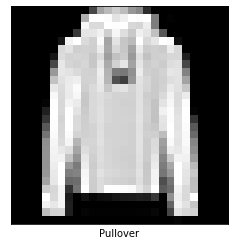

In [34]:
plotPredictions(scaled_test_images, test_labels, output_weights_s, labels_dictionary)

### Conclusiones

- Al aplicar datos sin escalar se observan que la optimización del costo y el accuracy del modelo fluctuan a lo largo del entrenamiento, e incluso en algunos casos obtener valores menos eficientes que los valores ya obtenidos en iteraciones previas
- Aplicar un learning rate pequeño logra reducir la fluctuación en datos no escalados, pero siguen generado ruido durante el entrenamiento
- El entrenamiento con datos previamente escalados facilita al algoritmo de GD trabajar de una forma suavizada que reduce las fluctuaciones y permiti que converja con mayor facilidad